# Gensim SE LDA Tutorial

If you need more structure and detail please review my chapter on applying LDA to Software Engineering Texts

http://webdocs.cs.ualberta.ca/~hindle1/2016/06Hindle.pdf

1. The first task involves acquiring the issue-tracker data and representing itin a convenient format such as JSON.
2. Then we transform the text of the input data, namely we convert the textto word counts, where words are represented as integer IDs.
3. We apply LDA software on the transformed documents to produce a topic-document matrix and a topic-word matrix.
4. We then summarize the top words from the topic-word matrix to produce topic-word summaries and store the topic-document matrix.
5. Finally, we analyze the document matrix and the topics. The objective of this analysis step is to (a) examine the latent topics discovered; (b)plot the topic relevance over time; and (c) cluster the issues (i.e., inputdocuments) according to their associated topics.


# Other references

RUN LDA Gensim Tutorial by Radim Řehůřek https://radimrehurek.com/gensim/auto_examples/tutorials/run_lda.html

In [34]:
import gensim
import json
import numpy
import numpy as np
import scipy
import matplotlib
import github 
import os
# pip3 install --user PyGithub gensim scipy numpy matplotlib
issues = []

# 4.2 Acquiring Data

You can skip this part if you have an existing `large.json`


In [2]:
config = json.load(open("config.json"))
USERNAME= os.environ.get("GHUSERNAME", config.get("GHUSERNAME",""))
PASSWORD= os.environ.get("GHPASSWORD", config.get("GHPASSWORD"))
g = github.Github(USERNAME,PASSWORD)
repo = g.get_repo("PyGithub/PyGithub")
print(repo)

Repository(full_name="PyGithub/PyGithub")


In [3]:
max_issues = 2000
issues_iter = repo.get_issues(state="all")
issues = []
count = 0
for issue in issues_iter:
    issues.append(issue)
    count += 1
    if count > max_issues:
        break

print(len(issues))    

1683


In [4]:
print("Max issue number: %s %s" % 
      (max([issue.number for issue in issues]), len(issues)))

Max issue number: 1687 1683


In [5]:
issues[0]
print(issues[0].number)
print(issues[0].title)
print(issues[0].body)

1687
Expanding the PyGithub authorization to support multiple tokens
Heya!

I'm a PhD student that regularly uses PyGithub to gather data for research projects (for instance we used PyGithub to analyze the code review usage and CI usage of ~700 open-source projects, [see this paper for instance](https://cassee.dev/files/CI-silent.pdf)). When using PyGithub to make millions of GET requests over the period  of a few months we often pool the tokens of several researchers involved in the project, and use a scraper that dynamically switches tokens based on actual rate limits. 

However, writing this code is often a pain, as it requires messing with the internals of PyGithub. Recently, I started working on an update to PyGithub that allows you to pass in a list of tokens instead of a single token. Internally, PyGithub then does the switching of tokens, abstracting it away. 

However, I'm not sure if this feature is of interest to more users of PyGithub. If so, I'm open to discussing on how I

In [6]:
def blank_none(v):
    if v is None:
        return ""
    return v
rows = [{"doc":{"_id":issue.number, "title":issue.title, "content":blank_none(issue.body)}}
        for issue in issues]
large_json = {"rows":rows}
json.dump(large_json,open("pylarge.json","w"))

# 4.3. Text Analysis and Data Transformation

* Loading text
* Transforming text
* Lexical analysis of text
* Optionally removing stop words
* Optionally stemming
* Optionally removing uncommon or very common words
* Building a vocabulary 
* Transforming each text document into a word-bag / word-vector


# Loading Text

In [7]:
import json
ALPHA=0.01
BETA=0.01
PASSES=10
TOPICS=20
INPUT="large.json"

def read_json_file( filename ):
    jsonsdata = open(filename).read()
    data = json.loads(jsonsdata)
    return read_json_data( data )

def read_json_data( data ):
    ldocs = [ row["doc"] for row in data["rows"] ]
    docs = {}
    for doc in ldocs:
        docs[doc["_id"]] = doc
    ids = [ doc["_id"] for doc in ldocs ]
    ids.sort()
    return  docs, ids

def text_summary(document):
    if (document is None):
        document = {}
    return document.get("title","") + " \n" + document.get("content","")



In [8]:
if "issues" in locals() and len(issues) > 0:
    print("Using PyGithub")
    ldocs, lids = read_json_data( large_json )
else:
    print("Loading %s" % INPUT)
    ldocs, lids = read_json_file( INPUT )


Loading large.json


In [9]:
ldocs[lids[-1]]

{'_id': 975,
 'created_at': '2015-04-03 02:31:27 UTC',
 'reportedBy': 'Karlheinzniebuhr',
 'owner': '',
 'content': 'anti FLOODING mecanism\nIt is possible to flood a group with messages, it should be blocked after some consecutively messages are being send from one person, can this be implemented ? ',
 'comments': [{'content': 'Not client related.', 'author': 'DrKLO'}]}

In [10]:
text_summary(ldocs[lids[50]])

' \nAdded spanish localization.\nI added the Spanish translation for Telegram. It was also completely revised on small screens.\r\n![screenshot_2014-01-28-18-05-15](https://f.cloud.github.com/assets/172758/2021976/07012dac-8847-11e3-804a-f73a11cc8cf2.png)\r\n'

# Transforming Text

In [11]:
# Get the text content out
texts = [text_summary(ldocs[lid]) for lid in lids]


* Lexical analysis of text
* Optionally removing stop words
* Optionally stemming
* Optionally removing uncommon or very common words
* Building a vocabulary 

## Remove Stop Words

In [12]:
# Make the vocabulary

from gensim.parsing.porter import PorterStemmer
from gensim.parsing.preprocessing import remove_stopwords # removing stop words
from gensim.parsing.preprocessing import preprocess_string # splitting 
from gensim.corpora.dictionary import Dictionary # build vocabulary

# remove stop words and lowercase

texts = [remove_stopwords(text.lower()) for text in texts]
for i in range(10):
    print(i, " ", texts[i])


/usr/lib/python3/dist-packages/paramiko/pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from cryptography.hazmat.primitives.ciphers.algorithms in 48.0.0.
  "cipher": algorithms.TripleDES,
/usr/lib/python3/dist-packages/paramiko/transport.py:261: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from cryptography.hazmat.primitives.ciphers.algorithms in 48.0.0.
  "class": algorithms.TripleDES,


0   added readme
1   can't import build code eclipse able import build code eclipse, source folder empty. classes java folder copy source folder lot errors.
2   language sounds like good initiative, better spanish. help translations spanish.
3   smiley don't smiley don't come notification. open keyboard open smiley. android 4.4.2
4   encrypted groups plan implement encrypted group conversations?
5   default sms setting application looks amazing feature request. i'm familiar android development sweet feature able telegram default sms. functionality (shown image) introduced kitkat definitely turn power user. ![screenshot_2013-12-16-08-55-03 1](https://f.cloud.github.com/assets/3226939/1755314/b4273460-6662-11e3-852e-ca76837d2364.png)
6   possible mitm attack "tab" mitm (at android client documentation clues it) : corrected version diffie-hellman (with nonce removed) server slip customers number zero modulo p g_a g_b (since documentation says 2048- bit sequence -- 0 p itself). clients ide

# Splitting documents into tokens

In [13]:
from gensim.parsing.preprocessing import strip_tags, strip_punctuation, strip_multiple_whitespaces, strip_numeric

# Note preprocess will stem by default, I just want to demonstrate stemming seperately

CUSTOM_FILTERS = [strip_tags, strip_punctuation, strip_multiple_whitespaces, strip_numeric]

tokenized = [preprocess_string(text, CUSTOM_FILTERS) for text in texts]

for i in range(10):
    print(i, " ", tokenized[i])

# Note that URLs are messed up by this


0   ['added', 'readme']
1   ['can', 't', 'import', 'build', 'code', 'eclipse', 'able', 'import', 'build', 'code', 'eclipse', 'source', 'folder', 'empty', 'classes', 'java', 'folder', 'copy', 'source', 'folder', 'lot', 'errors']
2   ['language', 'sounds', 'like', 'good', 'initiative', 'better', 'spanish', 'help', 'translations', 'spanish']
3   ['smiley', 'don', 't', 'smiley', 'don', 't', 'come', 'notification', 'open', 'keyboard', 'open', 'smiley', 'android']
4   ['encrypted', 'groups', 'plan', 'implement', 'encrypted', 'group', 'conversations']
5   ['default', 'sms', 'setting', 'application', 'looks', 'amazing', 'feature', 'request', 'i', 'm', 'familiar', 'android', 'development', 'sweet', 'feature', 'able', 'telegram', 'default', 'sms', 'functionality', 'shown', 'image', 'introduced', 'kitkat', 'definitely', 'turn', 'power', 'user', 'screenshot', 'https', 'f', 'cloud', 'github', 'com', 'assets', 'b', 'e', 'e', 'cad', 'png']
6   ['possible', 'mitm', 'attack', 'tab', 'mitm', 'at', 'andr

## Stemming

In [14]:
# Stemming doesn't always help
stemmer = PorterStemmer()

def stem_document(p,doc):
    return [p.stem(word) for word in doc]

stemmed = [stem_document(stemmer,doc) for doc in tokenized]

for i in range(10):
    print(i, " ", stemmed[i])
    
# # disable stemming
stemmed = tokenized

0   ['ad', 'readm']
1   ['can', 't', 'import', 'build', 'code', 'eclips', 'abl', 'import', 'build', 'code', 'eclips', 'sourc', 'folder', 'empti', 'class', 'java', 'folder', 'copi', 'sourc', 'folder', 'lot', 'error']
2   ['languag', 'sound', 'like', 'good', 'initi', 'better', 'spanish', 'help', 'translat', 'spanish']
3   ['smilei', 'don', 't', 'smilei', 'don', 't', 'come', 'notif', 'open', 'keyboard', 'open', 'smilei', 'android']
4   ['encrypt', 'group', 'plan', 'implement', 'encrypt', 'group', 'convers']
5   ['default', 'sm', 'set', 'applic', 'look', 'amaz', 'featur', 'request', 'i', 'm', 'familiar', 'android', 'develop', 'sweet', 'featur', 'abl', 'telegram', 'default', 'sm', 'function', 'shown', 'imag', 'introduc', 'kitkat', 'definit', 'turn', 'power', 'user', 'screenshot', 'http', 'f', 'cloud', 'github', 'com', 'asset', 'b', 'e', 'e', 'cad', 'png']
6   ['possibl', 'mitm', 'attack', 'tab', 'mitm', 'at', 'android', 'client', 'document', 'clue', 'it', 'correct', 'version', 'diffi', 'hel

# Building a Vocabulary

In [15]:
vocab = Dictionary( stemmed )
print(len(vocab))


5157


## Optionally removing uncommon or very common words

In [16]:
vocab.filter_extremes(no_below=2, no_above=0.5)
print(len(vocab))


2296


# Transforming each text document into a word-bag / word-vector

In [17]:
# Convert documents into bag of words representation

corpus = [vocab.doc2bow(doc) for doc in stemmed]
print("(ID,COUNT)")
print(corpus[0])
print("Should be 4 of 1 word")
print(vocab.doc2bow(['asset','asset','asset','asset','png']))

print(len(corpus))

for i in range(10):
    print(i, " ", corpus[i])

(ID,COUNT)
[(0, 1), (1, 1)]
Should be 4 of 1 word
[(59, 1)]
974
0   [(0, 1), (1, 1)]
1   [(2, 1), (3, 2), (4, 1), (5, 1), (6, 2), (7, 1), (8, 2), (9, 1), (10, 1), (11, 3), (12, 2), (13, 1), (14, 1), (15, 2), (16, 1)]
2   [(17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 2), (24, 1)]
3   [(16, 2), (25, 1), (26, 1), (27, 2), (28, 1), (29, 1), (30, 2), (31, 3)]
4   [(32, 1), (33, 2), (34, 1), (35, 1), (36, 1), (37, 1)]
5   [(2, 1), (25, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 2), (45, 1), (46, 1), (47, 2), (48, 1), (49, 2), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 2), (66, 1), (67, 1), (68, 1)]
6   [(16, 2), (25, 1), (41, 1), (43, 1), (52, 1), (69, 2), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1), (75, 1), (76, 1), (77, 1), (78, 2), (79, 1), (80, 1), (81, 1), (82, 1), (83, 1), (84, 2), (85, 2), (86, 2), (87, 1), (88, 1), (89, 5), (90, 1), (91, 2), (92, 1), (93

# 4.4. Applying LDA

In [19]:
import gensim
dumb_dictionary_bug = vocab[0]
id2word = vocab.id2token
lda = gensim.models.LdaModel(
    corpus,
    num_topics=TOPICS,
    id2word=id2word,
    passes=PASSES,
    alpha=ALPHA,
    eval_every=5,
    eta=BETA
)

# Summarize top topic words

In [20]:
from pprint import pprint
num_words = 10

chars = 12
template = "%" + str(chars) + "." + str(chars) + "s"

def top_topics_report(lda, corpus, num_words):
    top_topics = lda.top_topics(corpus, topn=num_words)
    rows = []
    i = 0
    for topic in top_topics:
        rows.append(("%3d" % i) + " ".join([template % topic[0][i][1] for i in range(num_words)]))
        i += 1
    report = "\n".join(rows)
    return report, top_topics

report, top_topics = top_topics_report(lda, corpus, num_words)
pprint(top_topics)
print(report)

[([(0.048175566, 'https'),
   (0.048062693, 'e'),
   (0.047483023, 'com'),
   (0.045059953, 'assets'),
   (0.04452351, 'cloud'),
   (0.037465073, 'png'),
   (0.035603795, 'githubusercontent'),
   (0.020579282, 'screenshot'),
   (0.014596489, 'intent'),
   (0.013338436, 'telegram')],
  -1.1684859911359193),
 ([(0.06336337, 'message'),
   (0.04789847, 'messages'),
   (0.023325682, 'user'),
   (0.018387131, 'notification'),
   (0.017154904, 'new'),
   (0.015786465, 'feature'),
   (0.015275783, 't'),
   (0.015264423, 'group'),
   (0.012372819, 'it'),
   (0.0119571015, 'way')],
  -1.6467329565376252),
 ([(0.030721309, 'telegram'),
   (0.01660554, 'emoji'),
   (0.014051399, 'i'),
   (0.013884336, 'message'),
   (0.013160933, 't'),
   (0.013104975, 'like'),
   (0.012940285, 's'),
   (0.011772735, 'app'),
   (0.011472889, 'it'),
   (0.0092719905, 'people')],
  -1.6800500346465659),
 ([(0.076287426, 'java'),
   (0.07005084, 'android'),
   (0.052419044, 'e'),
   (0.05030159, 'androidruntime'),
 

In [21]:
report, top_topics = top_topics_report(lda, corpus, num_words)
print(report)

  0       https            e          com       assets        cloud          png githubuserco   screenshot       intent     telegram
  1     message     messages         user notification          new      feature            t        group           it          way
  2    telegram        emoji            i      message            t         like            s          app           it       people
  3        java      android            e androidrunti         view     telegram          app           os       method activitythre
  4    telegram        error          org      android         java tmessagespro         file         help      project      problem
  5        chat     messages      message        group        sound notification       screen          app notification       option
  6    telegram      message notification      contact         read     messages      android         chat         list        chats
  7    telegram          app      contact            t        phone  

# Associate Documents with Topics

In [22]:
for i in range(10):
    doc_lda = lda[corpus[i]]
    print("%-40.40s" % str(doc_lda) + " | " + texts[i])

[(11, 0.9136311)]                        | added readme
[(5, 0.330389), (10, 0.66150194)]        | can't import build code eclipse able import build code eclipse, source folder empty. classes java folder copy source folder lot errors.
[(11, 0.72925985), (15, 0.251174)]       | language sounds like good initiative, better spanish. help translations spanish.
[(0, 0.98560494)]                        | smiley don't smiley don't come notification. open keyboard open smiley. android 4.4.2
[(13, 0.23826681), (19, 0.7367306)]      | encrypted groups plan implement encrypted group conversations?
[(0, 0.5365329), (4, 0.45862764)]        | default sms setting application looks amazing feature request. i'm familiar android development sweet feature able telegram default sms. functionality (shown image) introduced kitkat definitely turn power user. ![screenshot_2013-12-16-08-55-03 1](https://f.cloud.github.com/assets/3226939/1755314/b4273460-6662-11e3-852e-ca76837d2364.png)
[(1, 0.9977698)]        

In [23]:
import gensim.matutils
sparse_document_topics = [lda[doc] for doc in corpus]
document_topics = gensim.matutils.corpus2dense( sparse_document_topics, num_terms = TOPICS )
document_topics


array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.11695256, 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.5001704 , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [24, 12]
plt.rcParams["image.aspect"] = 'auto' 

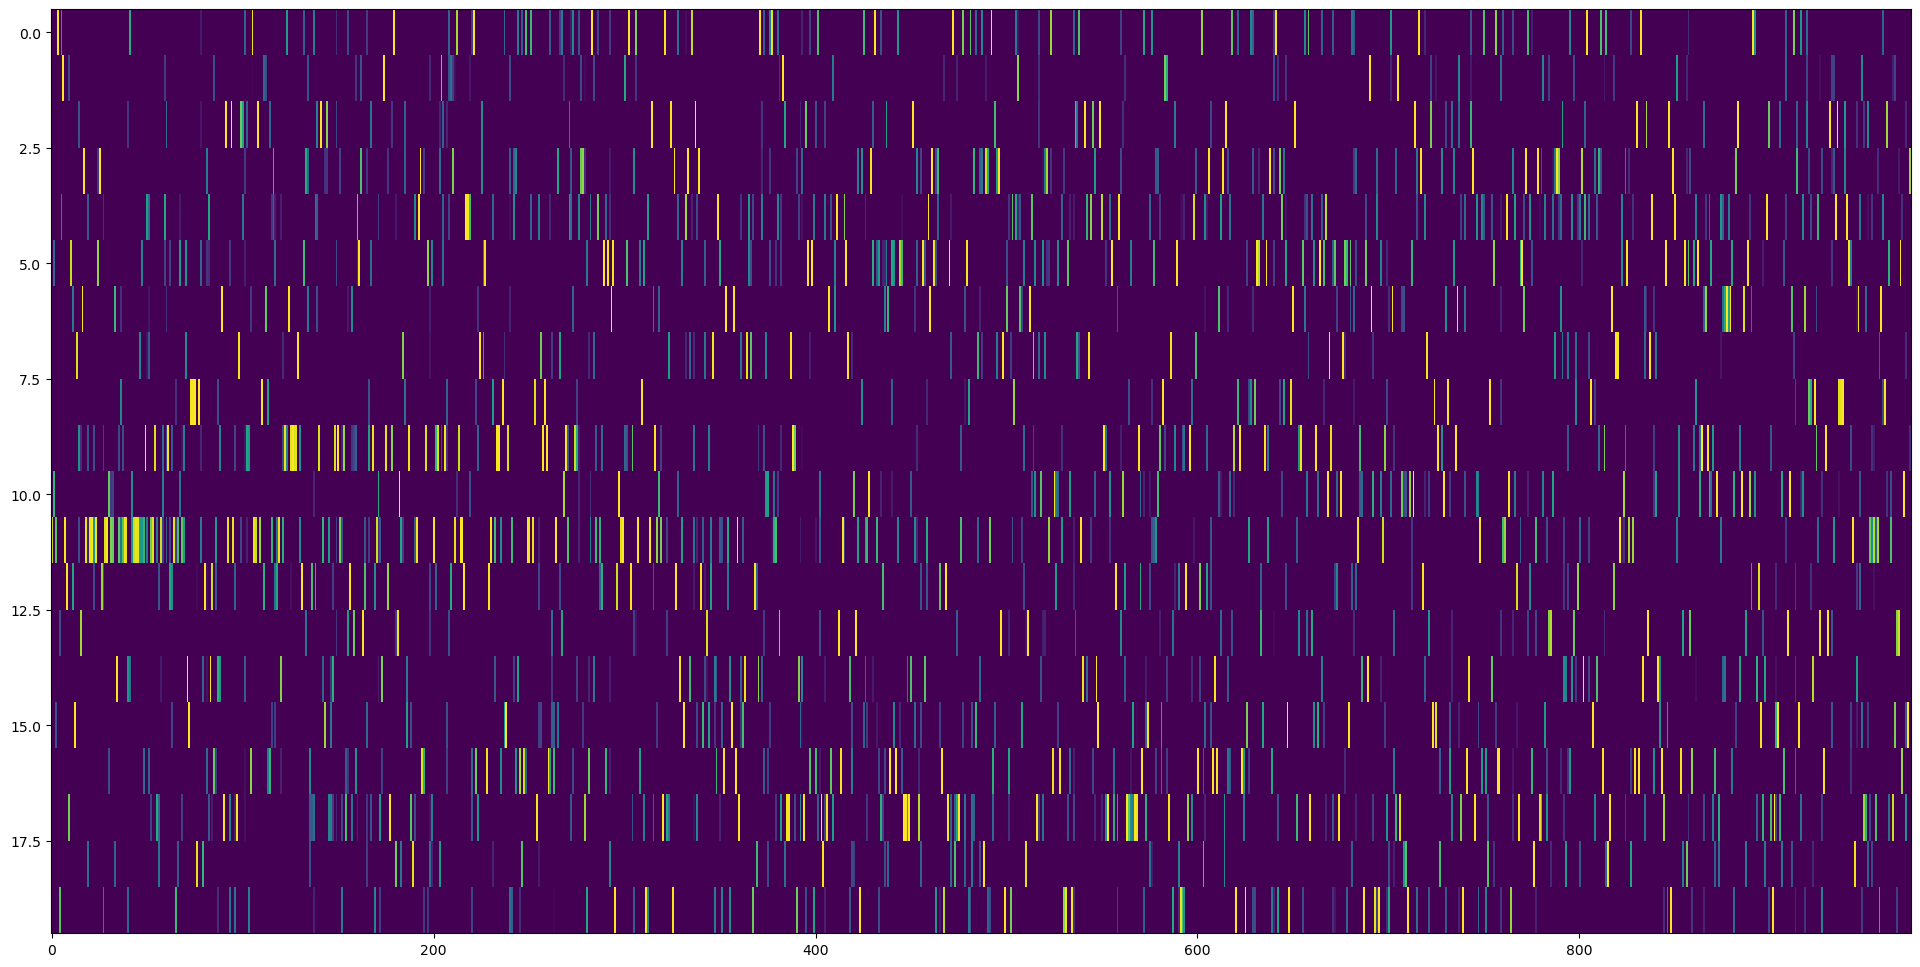

In [25]:
plt.imshow(document_topics, interpolation='none')
plt.show()


(974,)
(20, 974)


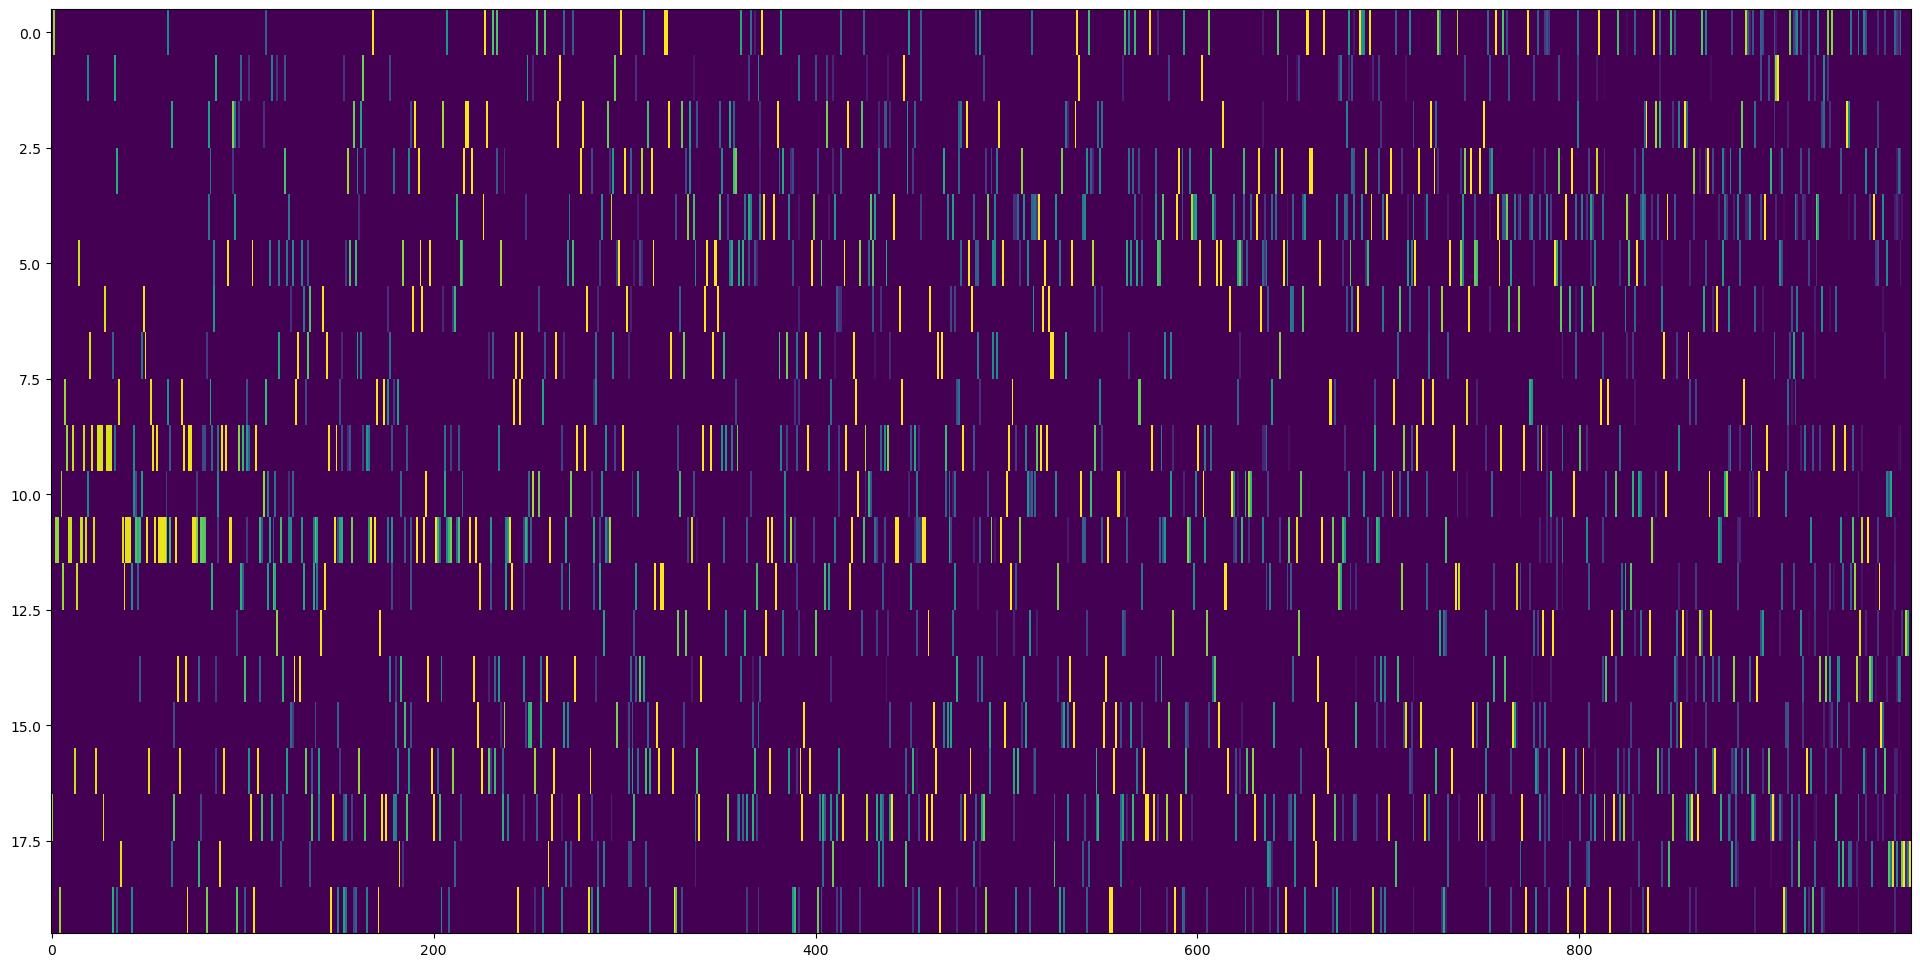

In [27]:
import numpy
# indices = np.arange(document_topics.shape[1])
sumsort = numpy.argsort(numpy.sum(document_topics,axis=0))
print(sumsort.shape)
print(document_topics.shape)
plt.imshow(document_topics[0:,sumsort], interpolation='none')
plt.show()



(1, 974)


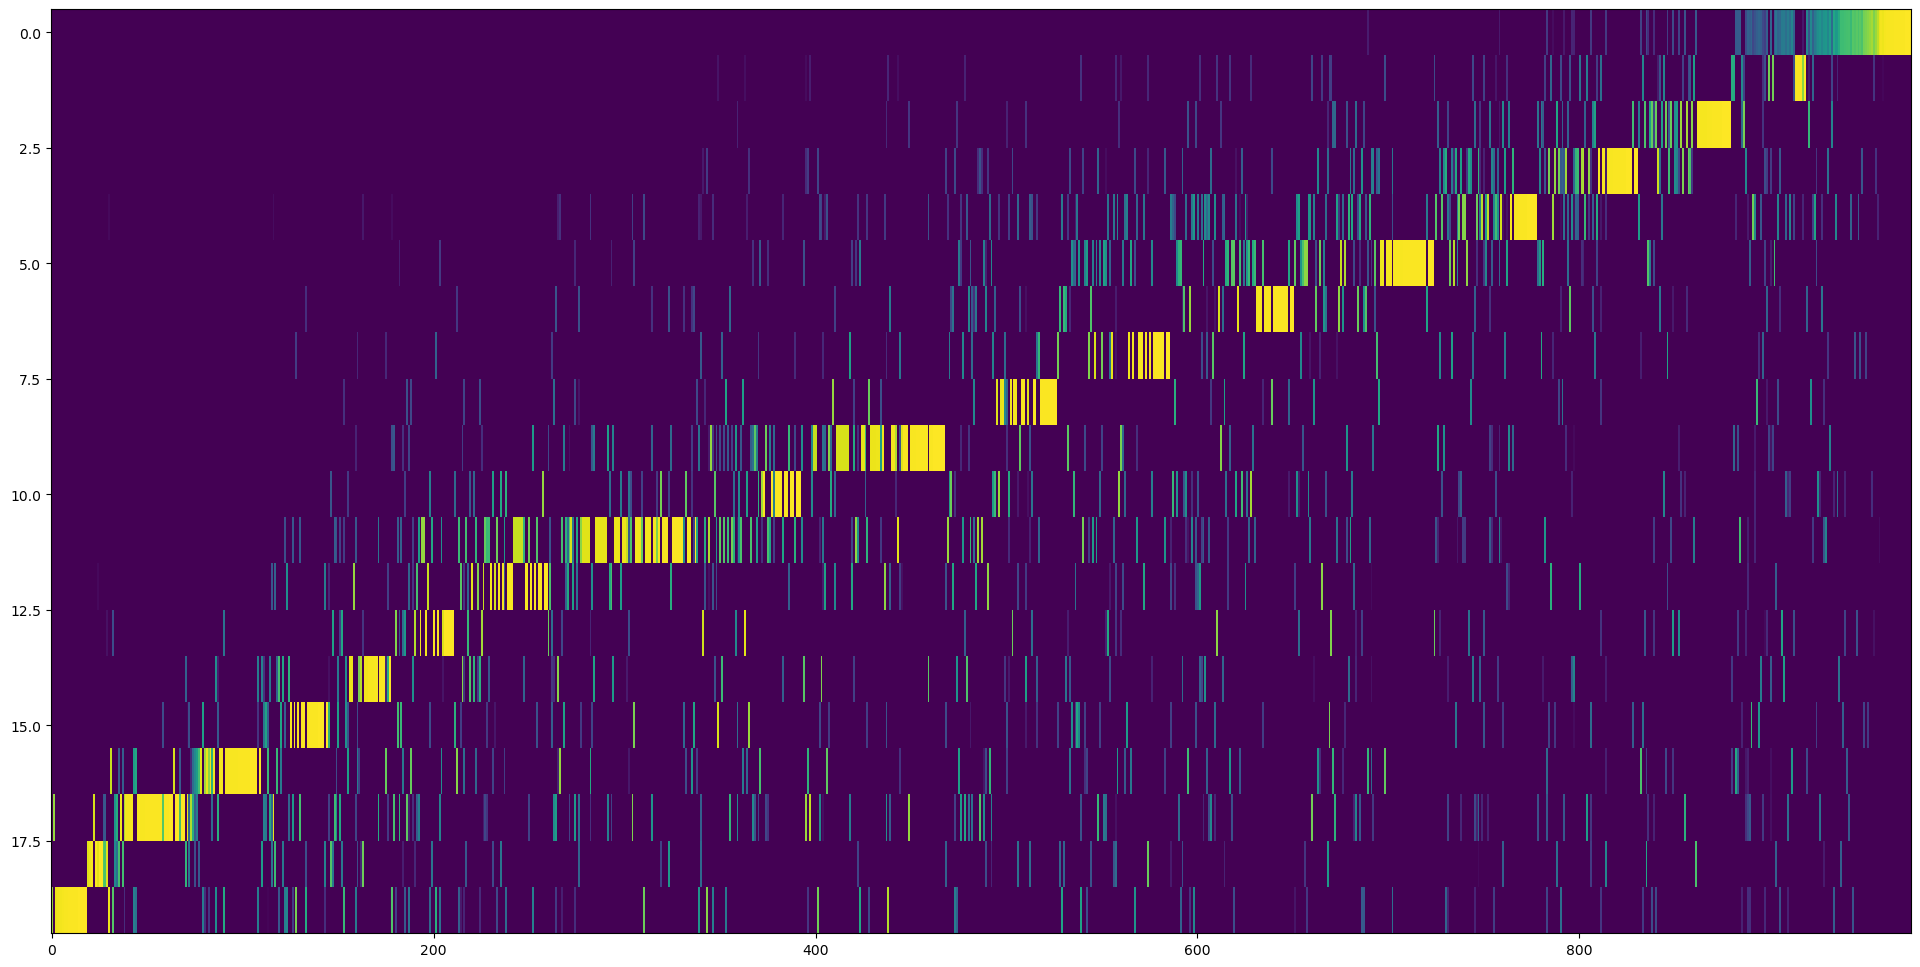

Topic 0
dev
ignore
verification sms way use sms verification ? remove 'telegam' sms ?
sms verifiction add sms gateway mobile number registration time signup
group based profiles nice change profile based group. groups want anonymous friends.
[question] what's sms gateway telegram? want know sms gateway. thank
cursor jumps deleting telephone number start screen (where telephone number typed in) cursor jumps end deleting telephone number middle
add function: block group. possible add feature ?. block user block group. want leave group, inviting. thank you.
set group photo times.please fix set group photos times.when try set group photo comes main chat screen.
consider menu direct button view contact button press menu button conversation expect options contact them, view information agenda attach directly. know press image it's hassle hurry.
Topic 19
properly fragments, activities separate package activities fragments named *activitiy. confusing different things. renamed classes extending

In [29]:
import numpy as np
# We're going to weight each topic by its reciprocal and then plot the documents, this is a form of clustering
weights = (1.0/np.arange(1,21))
weights = weights.reshape(1,TOPICS)
dw = np.asarray(numpy.matmul(weights, document_topics))
wsort = numpy.argsort(dw)
print(wsort.shape)
plt.imshow(document_topics[0:,wsort[0,0:]], interpolation='none')
plt.show()
print("Topic 0")
for i in wsort[0,0:10]:
    print(texts[i])
print("Topic 19")
for i in wsort[0,-10:-1]:
    print(texts[i])

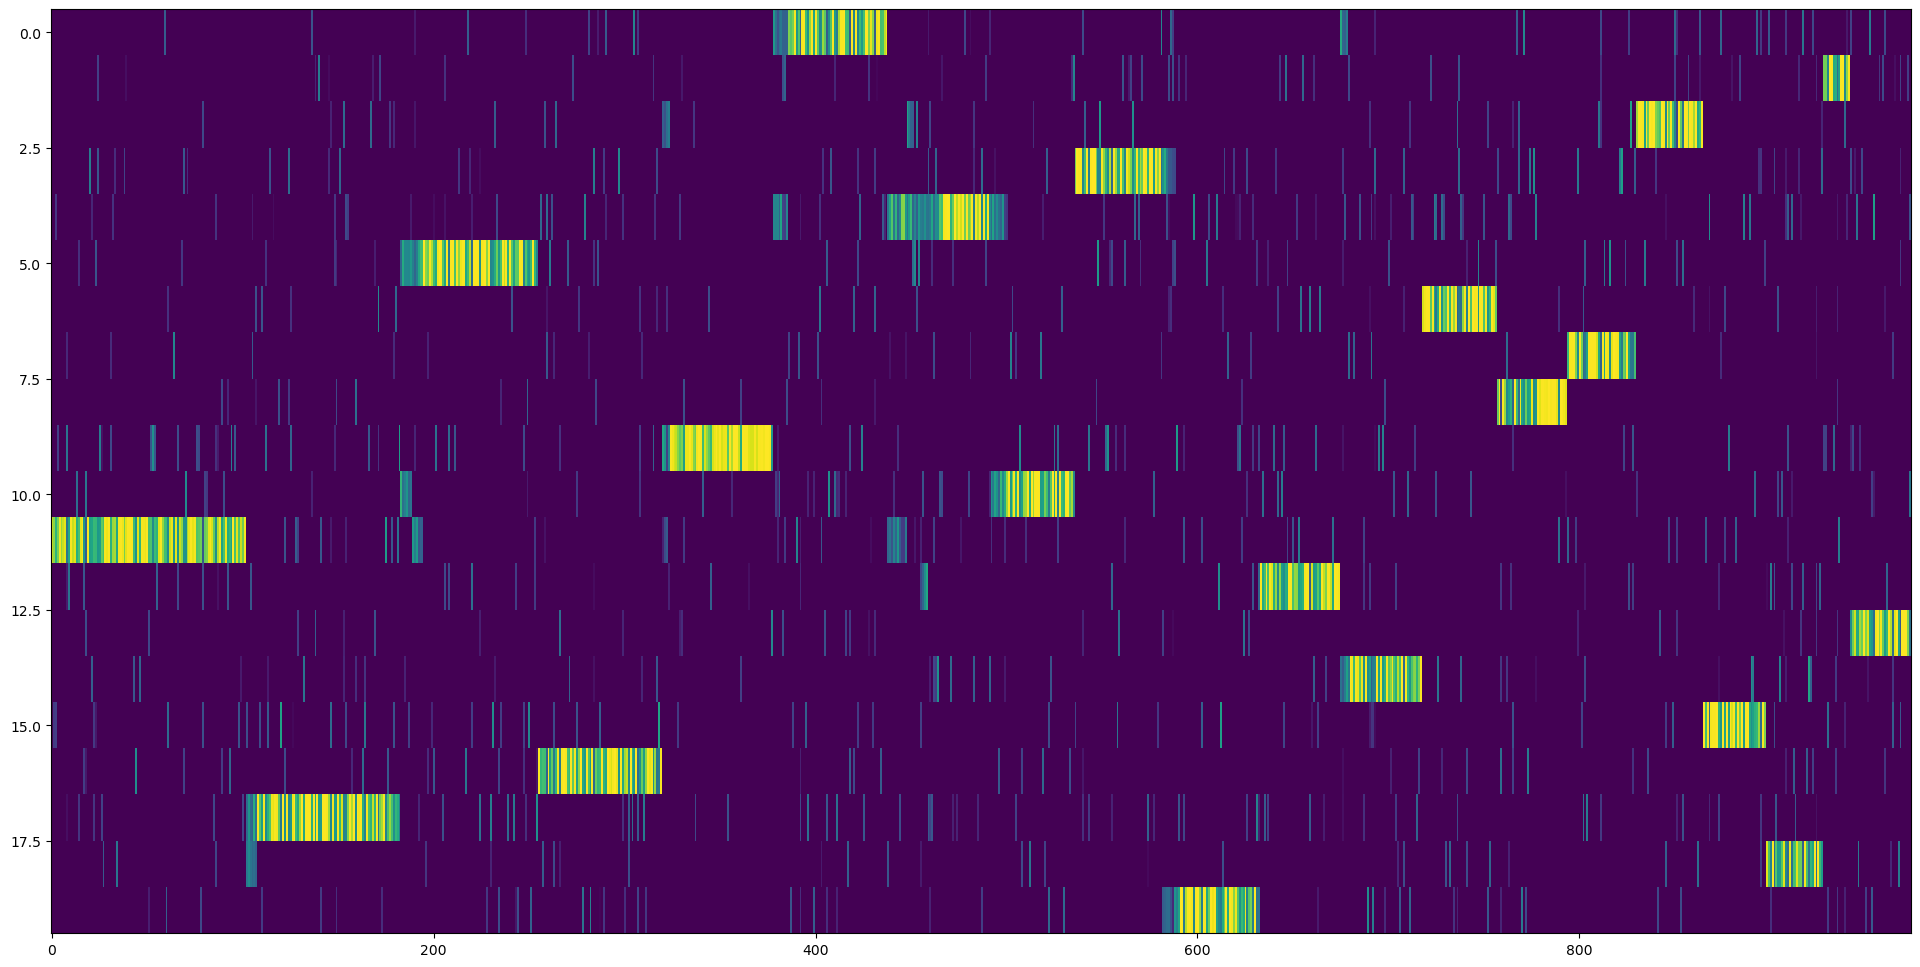

Topic FIRST
dev
ignore
verification sms way use sms verification ? remove 'telegam' sms ?
sms verifiction add sms gateway mobile number registration time signup
group based profiles nice change profile based group. groups want anonymous friends.
[question] what's sms gateway telegram? want know sms gateway. thank
cursor jumps deleting telephone number start screen (where telephone number typed in) cursor jumps end deleting telephone number middle
add function: block group. possible add feature ?. block user block group. want leave group, inviting. thank you.
set group photo times.please fix set group photos times.when try set group photo comes main chat screen.
consider menu direct button view contact button press menu button conversation expect options contact them, view information agenda attach directly. know press image it's hassle hurry.
Topic LAST
properly fragments, activities separate package activities fragments named *activitiy. confusing different things. renamed classes ext

In [30]:
# Document Similarity via cosine distance and hierarchical clustering
from scipy.cluster.hierarchy import ward, fcluster
from scipy.spatial.distance import pdist
Z = ward(pdist(document_topics.transpose(),'cosine'))
assignment = fcluster(Z, t=0.9, criterion='distance')
indices = numpy.argsort(assignment)
plt.imshow(document_topics[0:,indices], interpolation='none')
plt.show()
print("Topic FIRST")
for i in wsort[0,0:10]:
    print(texts[i])
print("Topic LAST")
for i in wsort[0,-10:-1]:
    print(texts[i])
print("OK let's look at cluster 5")
for i in numpy.argsort(assignment==5)[-10:-1]:
    print(texts[i])


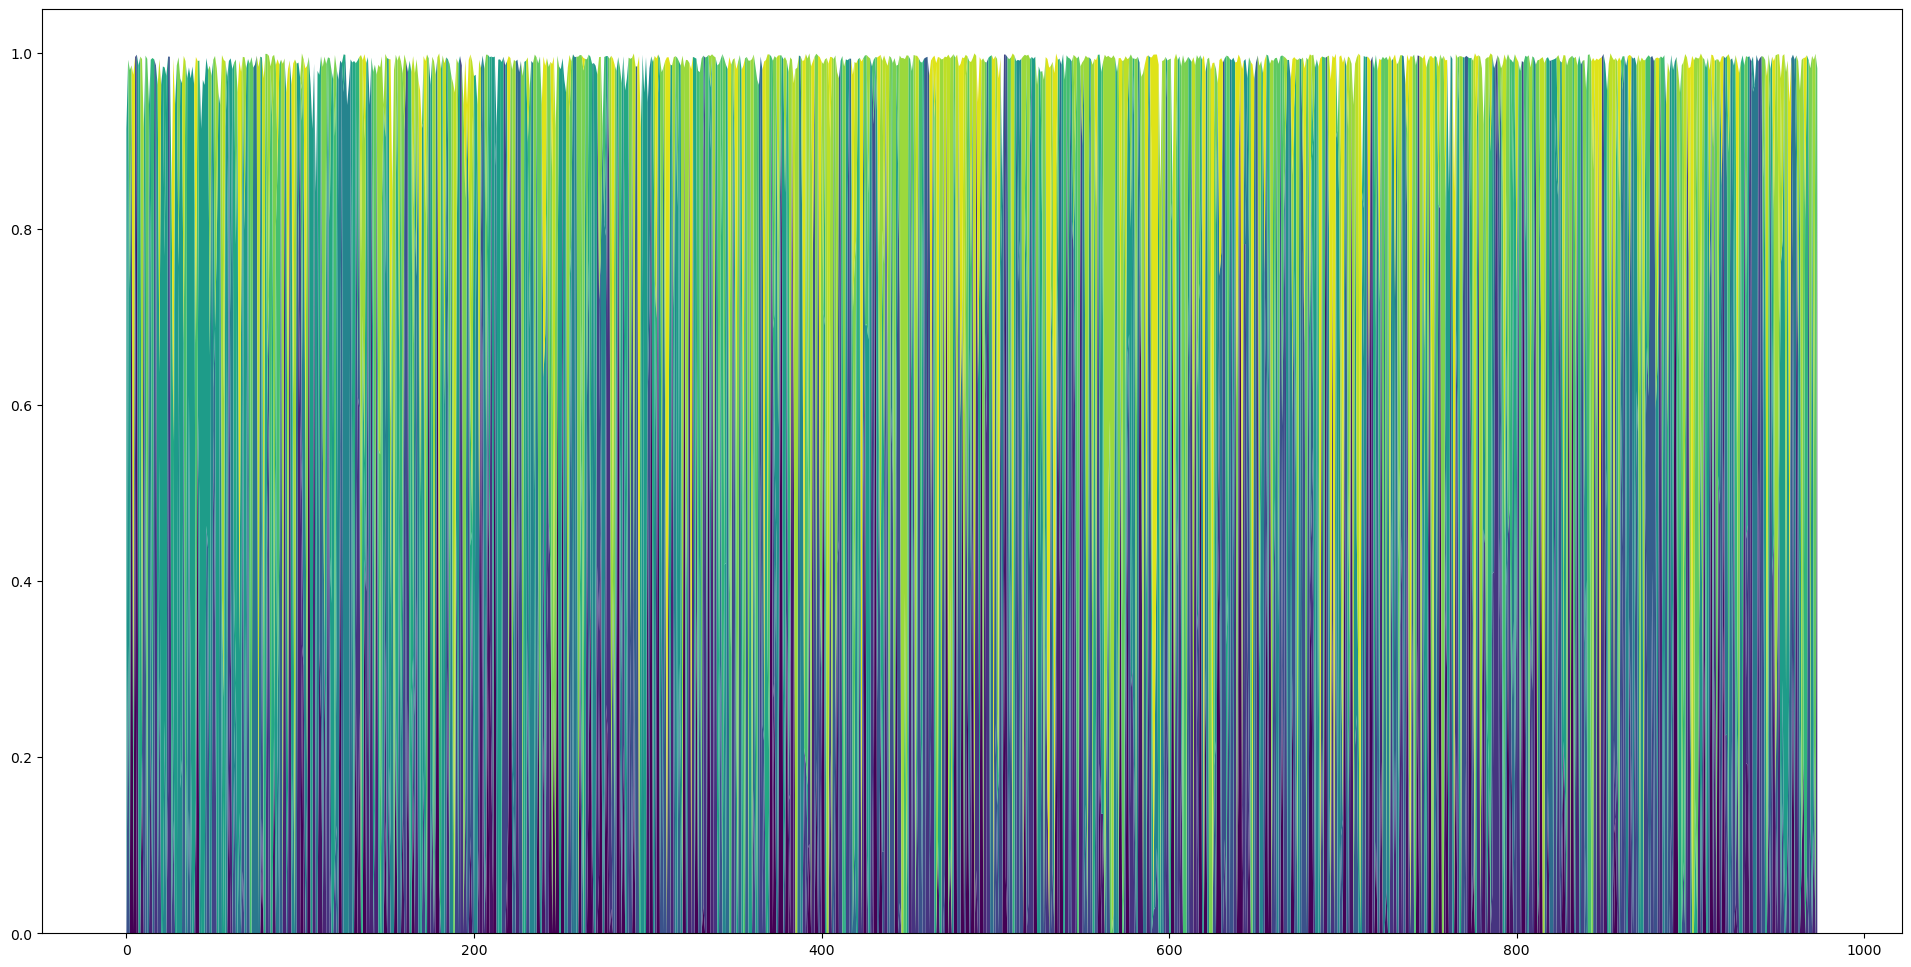

In [31]:
# Stack plot of topics

N = document_topics.shape[1]
ind = np.arange(N)[0:]
colours = plt.cm.viridis([x/TOPICS for x in range(TOPICS)])
plt.stackplot(ind,document_topics[0:,ind],colors=colours)
plt.show()



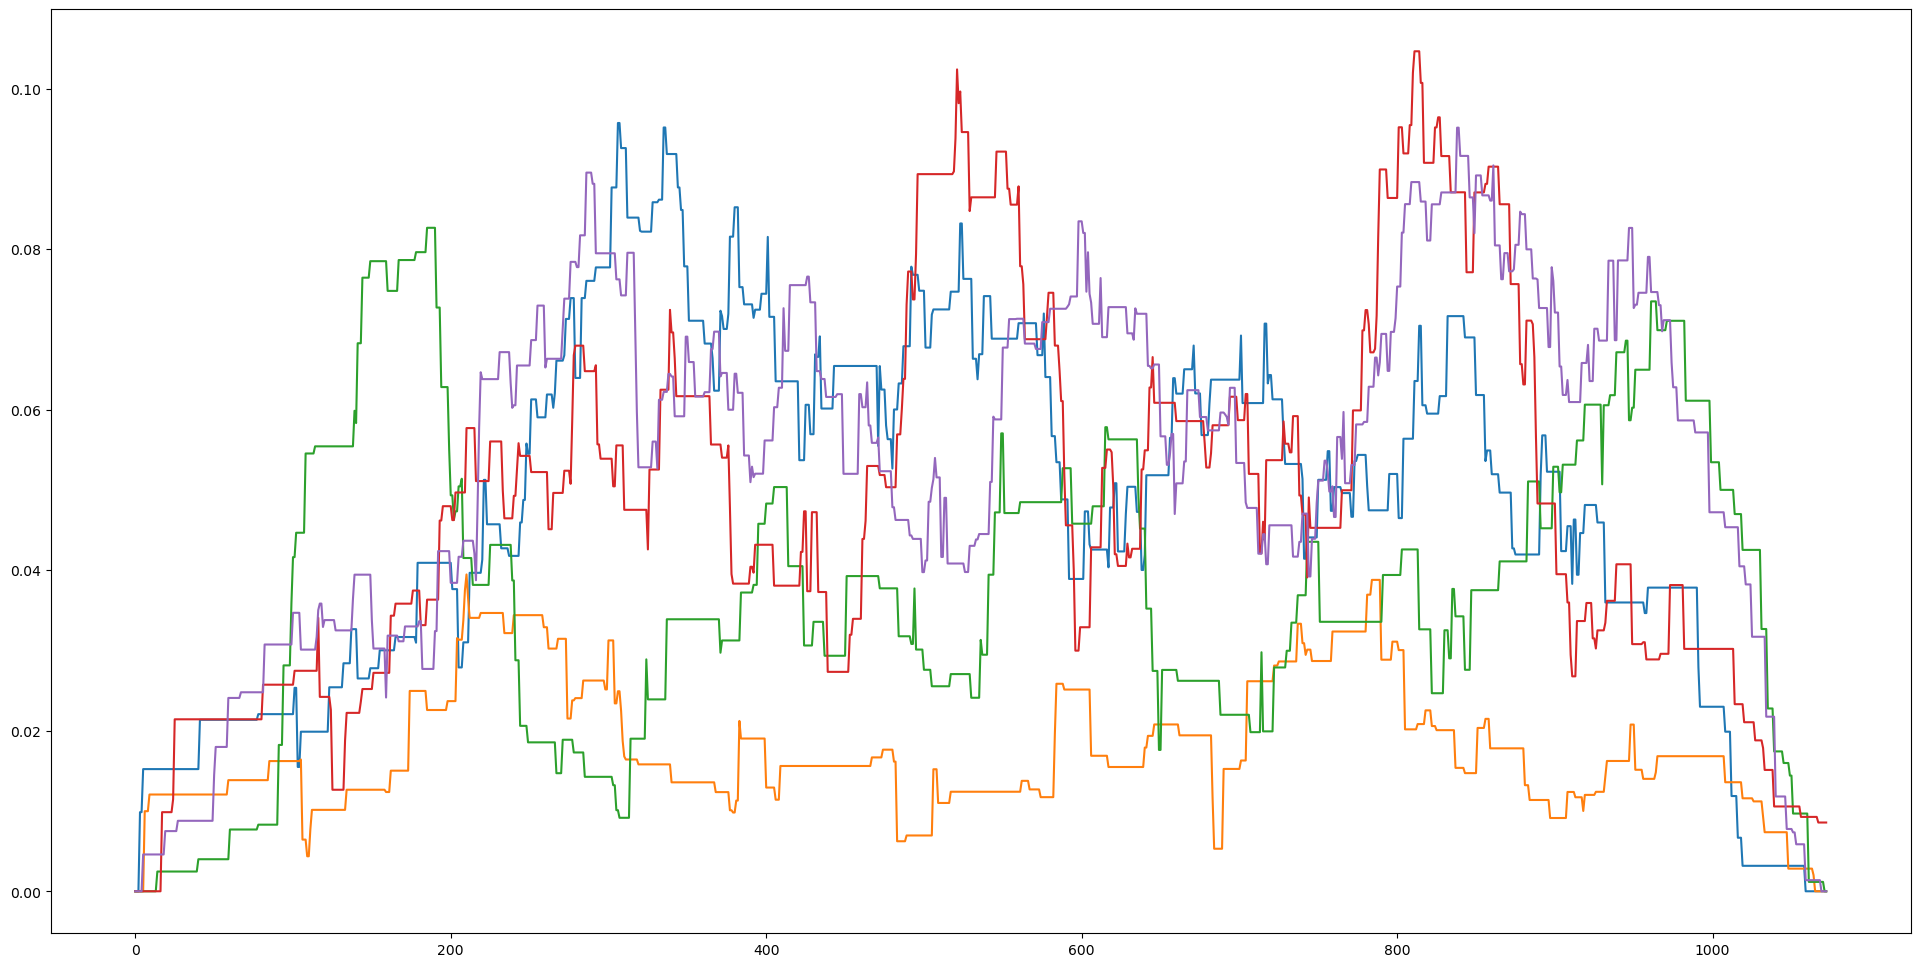

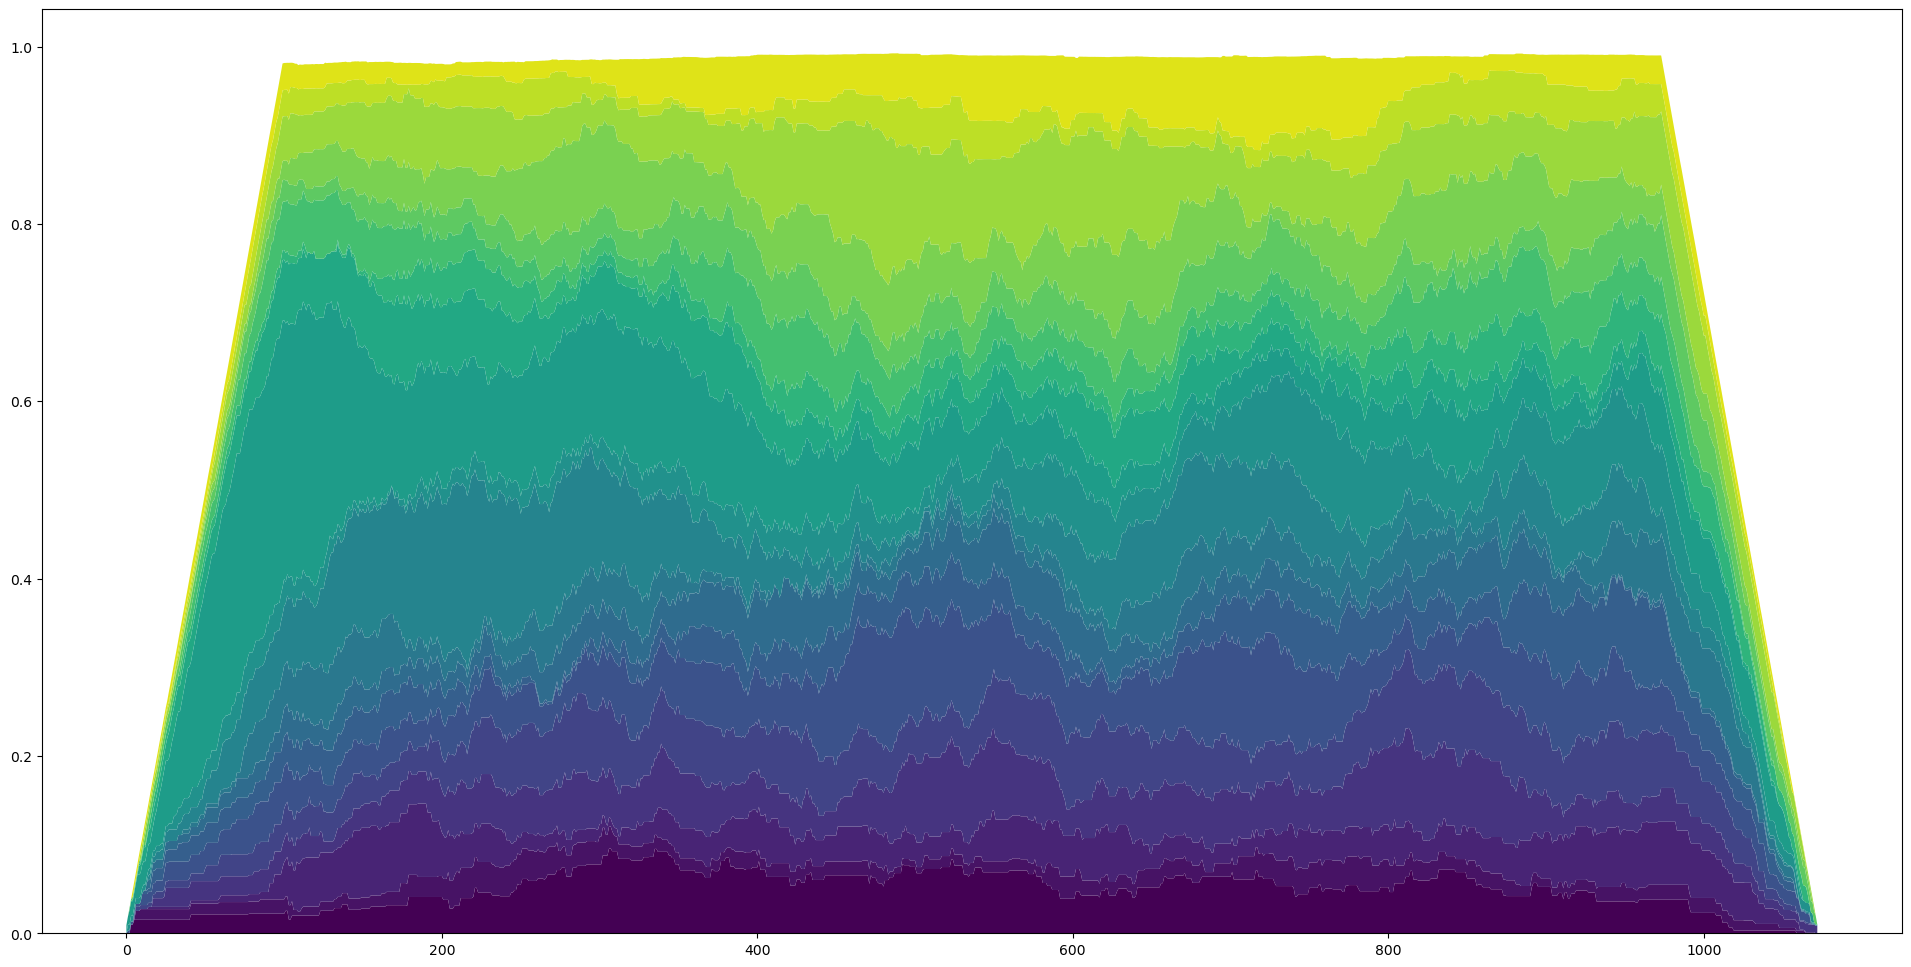

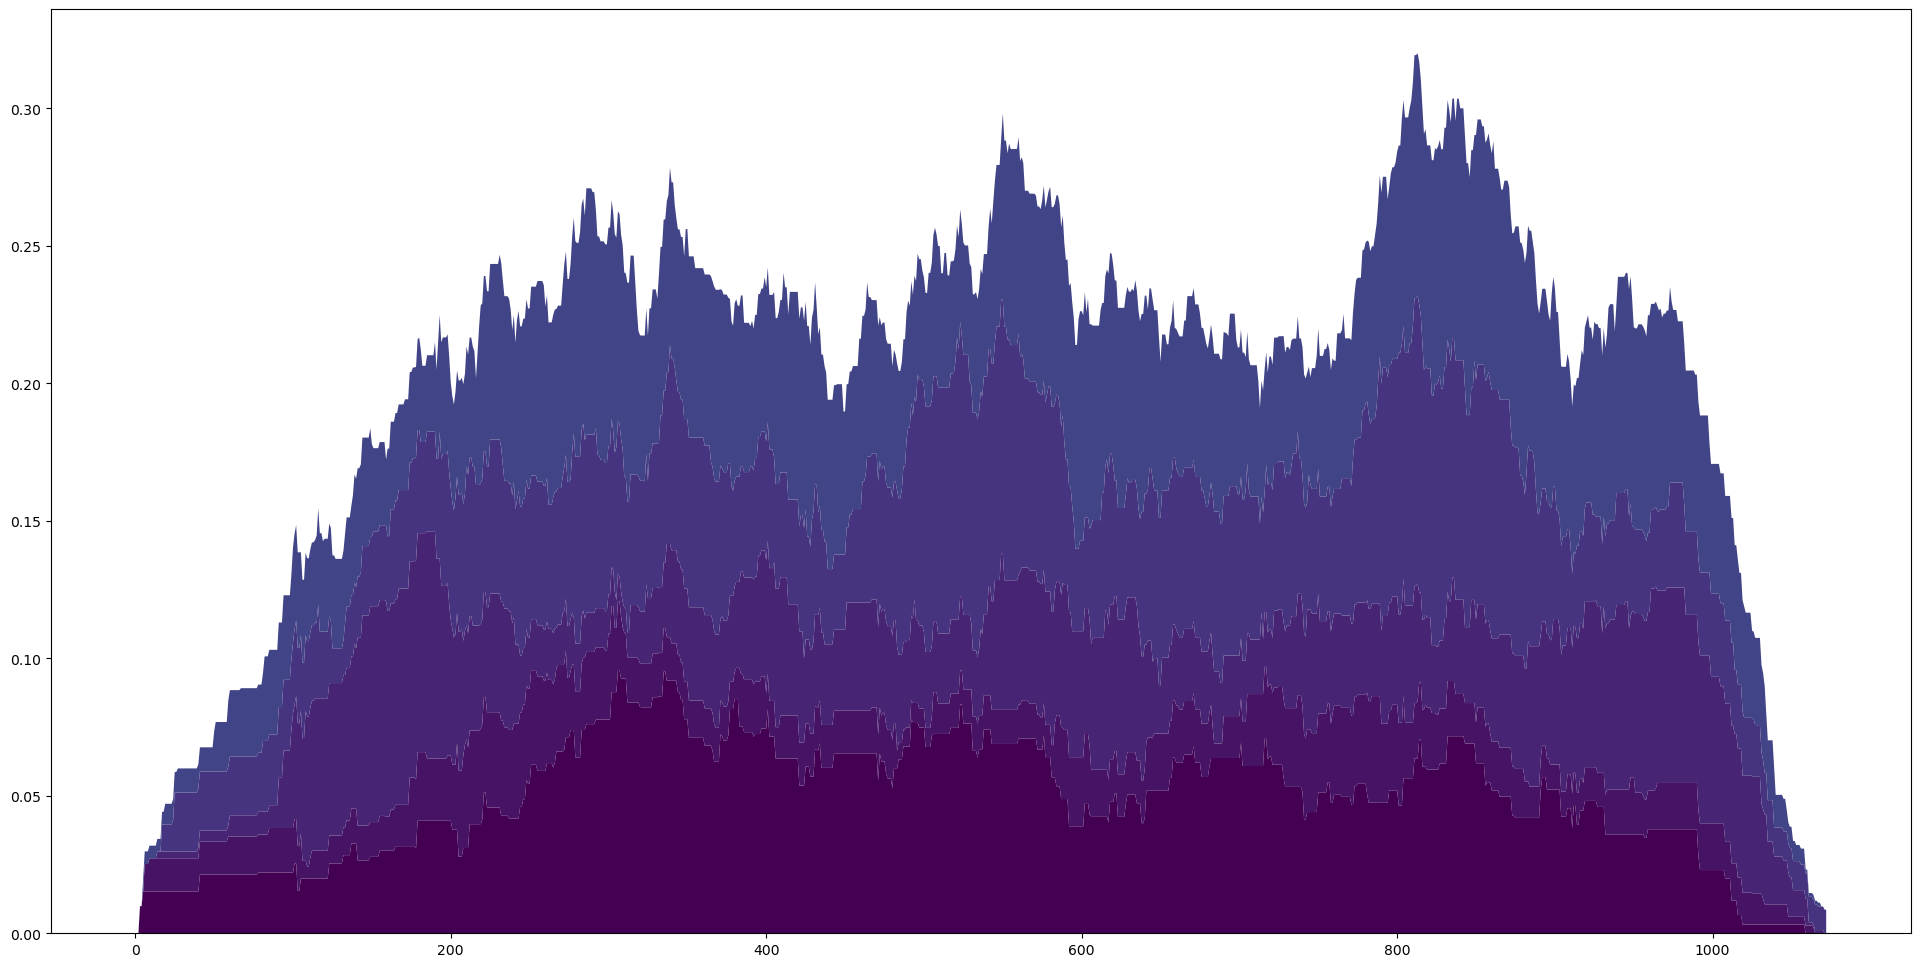

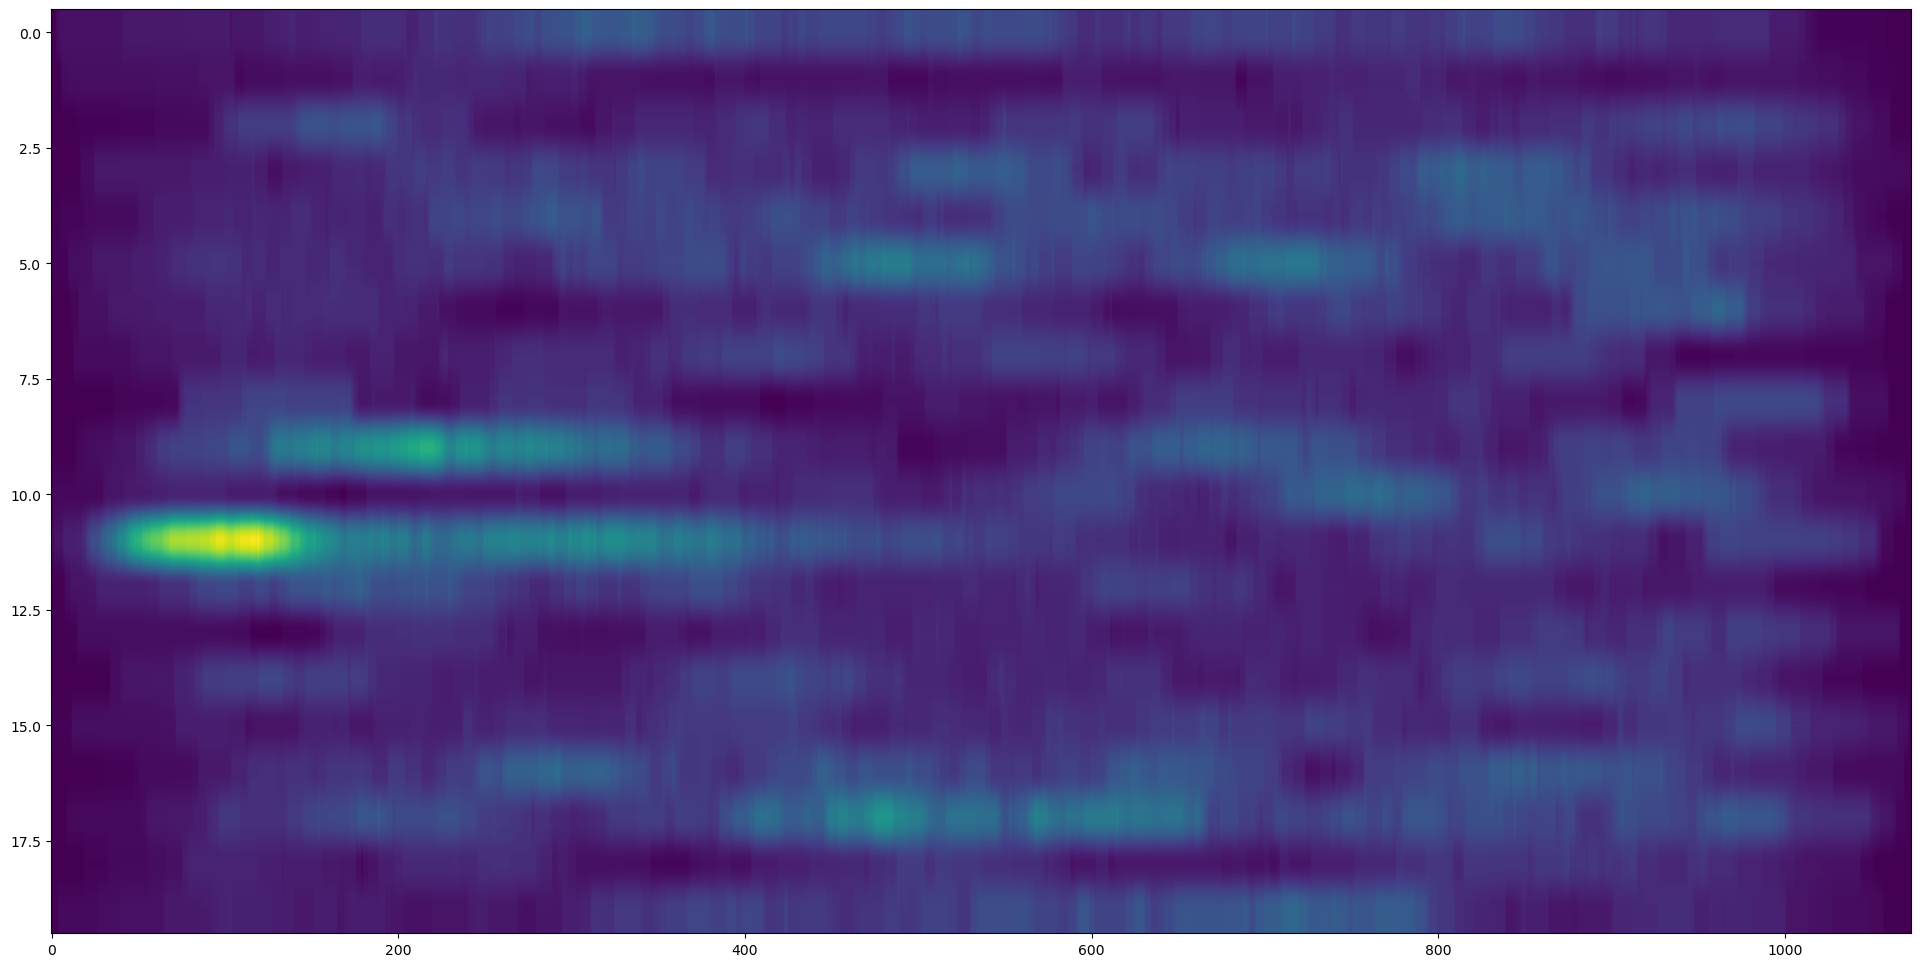

In [32]:
# Topic popularity over time

def moving_average(X,bins):
    length = X.shape[0]
    return np.convolve(X, np.ones(bins)/bins)

N = document_topics.shape[1]
ind = np.arange(N)
for i in range(5):
    plt.plot(moving_average(document_topics[i,ind],100))
plt.show()
mavg = np.array([
    moving_average(document_topics[i,ind],100) for i in range(TOPICS)
])
plt.stackplot(np.arange(mavg.shape[1]),mavg,colors=colours)
plt.show()
plt.stackplot(np.arange(mavg.shape[1]),mavg[0:5,0:],colors=colours)
plt.show()
plt.imshow(mavg)
plt.show()
